In [28]:
import pandas as pd
from pyspark.sql import SparkSession
import socket
import os

In [29]:
# Basic config values
APP_NAME = "TMDB-proj"
LOGIN = "sraza-476158"  # Your Kubernetes namespace
SPARK_IMAGE = f"node03.st:5000/spark-executor:{LOGIN}"

# Optional: Local IP (for driver host)
LOCAL_IP = socket.gethostbyname(socket.gethostname())

# Create Spark Session
spark = (
    SparkSession.builder
    .appName(APP_NAME)
    .master("k8s://https://10.32.7.103:6443")   # Your Kubernetes API endpoint
    
    # Driver Configurations
    .config("spark.driver.host", LOCAL_IP)
    .config("spark.driver.port", "7077")
    .config("spark.driver.cores", "1")
    .config("spark.driver.memory", "4g")
    
    # Executor Configurations
    .config("spark.executor.instances", "3")
    .config("spark.executor.cores", "2")
    .config("spark.executor.memory", "4g")
    
    # Kubernetes-specific configurations
    .config("spark.kubernetes.namespace", LOGIN)
    .config("spark.kubernetes.container.image", SPARK_IMAGE)
    .config("spark.kubernetes.container.image.pullPolicy", "Always")
    .config("spark.kubernetes.executor.deleteOnTermination", "true")

    # UI & Logging
    .config("spark.ui.port", "4040")
    
    # Temp storage
    .config("spark.local.dir", "/tmp/spark")
    
    .getOrCreate()
)

print("✅ Spark session successfully created for Kubernetes.")

✅ Spark session successfully created for Kubernetes.


In [ ]:
import pandas as pd
file_path = '/home/jovyan/nfs-home/full_tmdb_dataset.parquet'
df_pandas = pd.read_parquet(file_path)

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.createDataFrame(df_pandas)
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- runtime: long (nullable = true)
 |-- budget: long (nullable = true)
 |-- revenue: long (nullable = true)
 |-- popularity: double (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: long (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- director: string (nullable = true)
 |-- director_of_photography: string (nullable = true)
 |-- writers: string (nullable = true)
 |-- producers: string (nullable = true)
 |-- music_composer: string (nullable = true)



### Data Cleaning and Transformation

In [ ]:
from pyspark.sql.functions import to_date, col, year
df = df.withColumn("release_date", to_date(col("release_date"), "yyyy-MM-dd"))
df = df.withColumn("release_date", to_date(col("release_date"), "yyyy-MM-dd"))
df = df.withColumn("release_year", year(col("release_date")))
df_clean = df.filter(col("release_year") <= 2025)
print(f"Total Rows After Filtering: {df_clean.count()}")

Total Rows After Filtering: 387881


### Data Aggregation and Analysis

#### Group By Year and Count Movies

In [33]:
from pyspark.sql.functions import count

yearly_df = df_clean.groupBy("release_year") \
                    .agg(count("*").alias("movie_count")) \
                    .filter(col("release_year").isNotNull()) \
                    .orderBy(col("movie_count").desc())

print("Top 10 Years by Movie Count:")
yearly_df.show(10)

Top 10 Years by Movie Count:
+------------+-----------+
|release_year|movie_count|
+------------+-----------+
|        2023|      15503|
|        2024|      15150|
|        2019|      14289|
|        2022|      14280|
|        2021|      13662|
|        2018|      13514|
|        2020|      12799|
|        2017|      12781|
|        2016|      11609|
|        2015|      10760|
+------------+-----------+
only showing top 10 rows



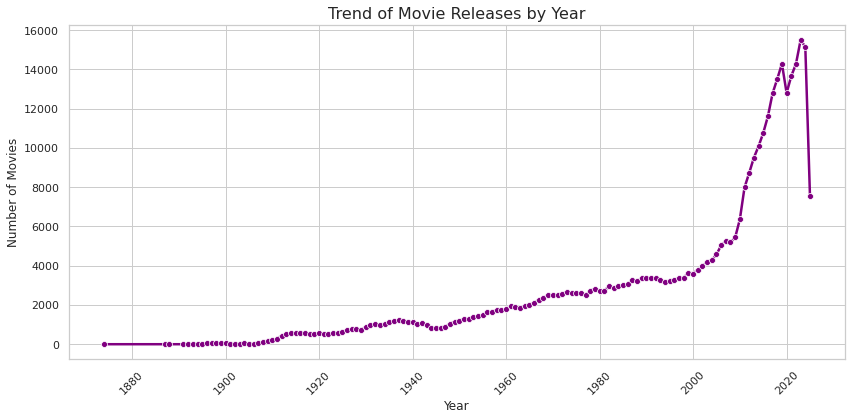

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

yearly_pd = yearly_df.orderBy("release_year").toPandas()

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

sns.lineplot(
    data=yearly_pd,
    x="release_year",
    y="movie_count",
    color="#800080",  
    marker="o",     
    linewidth=2.5
)

plt.title("Trend of Movie Releases by Year", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Movies", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Genre Count and Popularity

In [ ]:
from pyspark.sql.functions import split, explode, trim, regexp_replace

df_for_genre = df_clean.select("title", "genres")
df_exploded = df_for_genre.withColumn(
    "genres_clean", regexp_replace(col("genres"), "[|;:/]", ",")
)
df_exploded = df_exploded.withColumn("genre", explode(split(col("genres_clean"), ",")))

df_exploded = df_exploded.withColumn("genre", trim(col("genre"))).filter(
    ~(col("genre").isNull()) & (col("genre") != "")
)

genre_counts = df_exploded.groupBy("genre") \
                         .agg(count("*").alias("total")) \
                         .orderBy(col("total").desc())

genre_counts.show(10)

+-----------+------+
|      genre| total|
+-----------+------+
|      Drama|145119|
|     Comedy| 85413|
|Documentary| 53778|
|    Romance| 37342|
|   Thriller| 30707|
|     Action| 28979|
|     Horror| 27692|
|      Crime| 24294|
|   TV Movie| 21933|
|  Animation| 19409|
+-----------+------+
only showing top 10 rows



### Visualization

#### Top 10 Genres Bar Plot

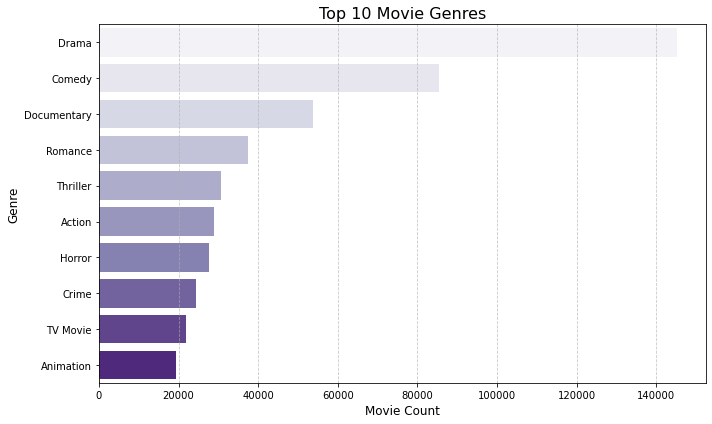

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

pandas_genres = genre_counts.limit(10).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=pandas_genres, x="total", y="genre", palette="Purples")

plt.title("Top 10 Movie Genres", fontsize=16)
plt.xlabel("Movie Count", fontsize=12)
plt.ylabel("Genre", fontsize=12)

plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

#### Which actor appeared in the most movies in 2023

In [56]:
from pyspark.sql.functions import col, year
from pyspark.sql.functions import count
from pyspark.sql.functions import split, explode, trim

df_2023 = df_clean.filter(col("release_year") == 2023)

df_cast_2023 = df_2023.withColumn(
    "cast_member", explode(split(trim(col("cast")), "[|,]"))
).withColumn("cast_member", trim(col("cast_member")))

df_cast_2023 = df_cast_2023.filter(
    col("cast_member").isNotNull() &
    (col("cast_member") != "")
)

actor_counts = df_cast_2023.groupBy("cast_member") \
                           .agg(count("*").alias("movie_count")) \
                           .orderBy(col("movie_count").desc())

actor_counts.show(10)

+-----------------+-----------+
|      cast_member|movie_count|
+-----------------+-----------+
|     Eric Roberts|         46|
|         Woo Yeol|         25|
|       Im Tae-mok|         21|
|        Yogi Babu|         21|
|      Min Do-yoon|         20|
|     Johny Antony|         19|
|           Si Woo|         19|
|           Do Hee|         17|
|  Vennela Kishore|         17|
|Shawn C. Phillips|         17|
+-----------------+-----------+
only showing top 10 rows



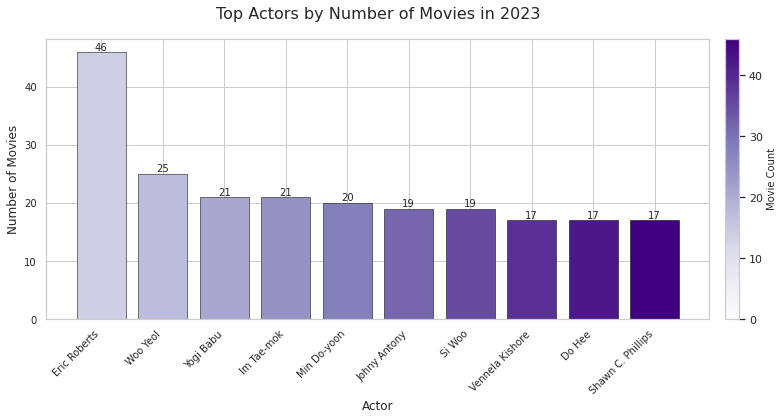

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

top_actors = actor_counts.limit(10).toPandas()

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

colors = plt.cm.Purples(np.linspace(0.3, 1, len(top_actors)))

bars = plt.bar(
    top_actors["cast_member"],
    top_actors["movie_count"],
    color=colors,
    edgecolor='black',
    linewidth=0.5
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        height,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title("Top Actors by Number of Movies in 2023", fontsize=16, pad=20)
plt.xlabel("Actor", fontsize=12)
plt.ylabel("Number of Movies", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

sm = plt.cm.ScalarMappable(cmap="Purples", norm=plt.Normalize(vmin=0, vmax=top_actors["movie_count"].max()))
sm.set_array([])
cbar = plt.colorbar(sm, pad=0.02)
cbar.set_label('Movie Count', fontsize=10)

plt.tight_layout()
plt.show()

#### Genre Popularity Over Time

In [58]:
from pyspark.sql.functions import split, explode, trim, regexp_replace
from pyspark.sql.functions import year

df_genre_analysis = df_clean.select("title", "genres", "release_date", "popularity", "vote_average", "vote_count")

df_exploded = df_genre_analysis.withColumn(
    "genres_clean", regexp_replace(col("genres"), "[|;:/]", ",")
).withColumn("genre", explode(split(col("genres_clean"), ",")))

df_exploded = df_exploded.withColumn("genre", trim(col("genre"))) \
                         .filter(~(col("genre").isNull()) & (col("genre") != ""))

df_exploded = df_exploded.withColumn("release_year", year(col("release_date")))

from pyspark.sql.functions import count, col

df_genre_time = df_exploded.groupBy("release_year", "genre") \
                           .agg(count("*").alias("movie_count")) \
                           .filter(col("release_year").between(1970, 2025)) \
                           .orderBy("release_year", "genre")

df_genre_time.show()

+------------+---------------+-----------+
|release_year|          genre|movie_count|
+------------+---------------+-----------+
|        1970|         Action|        184|
|        1970|      Adventure|        147|
|        1970|      Animation|         95|
|        1970|         Comedy|        542|
|        1970|          Crime|        199|
|        1970|    Documentary|        180|
|        1970|          Drama|       1023|
|        1970|         Family|        115|
|        1970|        Fantasy|         68|
|        1970|        History|         72|
|        1970|         Horror|        108|
|        1970|          Music|        122|
|        1970|        Mystery|         59|
|        1970|        Romance|        200|
|        1970|Science Fiction|         41|
|        1970|       TV Movie|        161|
|        1970|       Thriller|        111|
|        1970|            War|         89|
|        1970|        Western|         72|
|        1971|         Action|        214|
+----------

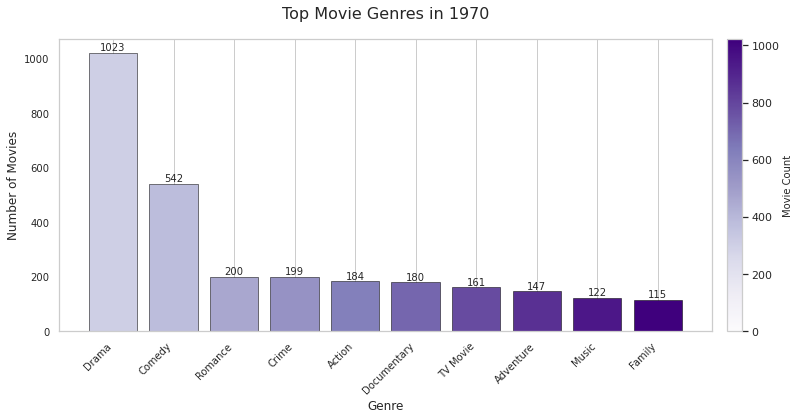

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pandas_genre_time = df_genre_time.toPandas()

YEAR_TO_PLOT = 1970  # ← Change this as needed

yearly_data = pandas_genre_time[pandas_genre_time["release_year"] == YEAR_TO_PLOT]

if yearly_data.empty:
    print(f"No data found for year {YEAR_TO_PLOT}")
else:
    top_genres = yearly_data.sort_values("movie_count", ascending=False).head(10)

    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    colors = plt.cm.Purples(np.linspace(0.3, 1, len(top_genres)))

    bars = plt.bar(
        top_genres["genre"],
        top_genres["movie_count"],
        color=colors,
        edgecolor='black',
        linewidth=0.5,
        zorder=2  
    )

    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            yval + 0.5,
            f'{int(yval)}',
            ha='center',
            va='bottom',
            fontsize=10
        )

    plt.title(f"Top Movie Genres in {YEAR_TO_PLOT}", fontsize=16, pad=20)
    plt.xlabel("Genre", fontsize=12)
    plt.ylabel("Number of Movies", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=1)

    sm = plt.cm.ScalarMappable(cmap="Purples", norm=plt.Normalize(vmin=0, vmax=top_genres["movie_count"].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, pad=0.02)
    cbar.set_label('Movie Count', fontsize=10)

    plt.tight_layout()
    plt.show()

#### Revenue and ROI Analysis

In [54]:
from pyspark.sql.functions import col, when

df_budget_roi = df_clean.select(
    "title",
    "release_year",
    "genres",
    col("budget").cast("double"),
    col("revenue").cast("double")
).filter((col("budget") > 0) & (col("revenue") > 0))

df_budget_roi = df_budget_roi.withColumn("profit", col("revenue") - col("budget")) \
                              .withColumn(
                                  "roi",
                                  when(col("budget") > 0, (col("revenue") - col("budget")) / col("budget") * 100)
                                    .otherwise(0.0)
                              ) \
                              .select("title", "release_year", "genres", "budget", "revenue", "profit", "roi")

top_roi_movies = df_budget_roi.filter(
    (col("budget") > 100000000) & (col("revenue") > 100000000) & (col("budget") < col("revenue") * 0.9)
).orderBy(col("roi").desc()).limit(10).toPandas()

top_roi_movies["budget"] = top_roi_movies["budget"].map(lambda x: f"${x:,.0f}")
top_roi_movies["revenue"] = top_roi_movies["revenue"].map(lambda x: f"${x:,.0f}")
top_roi_movies["roi"] = top_roi_movies["roi"].map(lambda x: f"{x:,.0f}%")

top_roi_movies_display = top_roi_movies[["title", "budget", "revenue", "roi", "release_year"]]
top_roi_movies_display

,title,budget,revenue,roi,release_year
0,Titanic,"$200,000,000","$2,264,162,353","1,032%",1997
1,Jurassic World,"$150,000,000","$1,671,537,444","1,014%",2015
2,Barbie,"$145,000,000","$1,445,638,421",897%,2023
3,Frozen II,"$150,000,000","$1,453,683,476",869%,2019
4,Spider-Man: No Way Home,"$200,000,000","$1,921,847,111",861%,2021
5,Top Gun: Maverick,"$170,000,000","$1,488,732,821",776%,2022
6,Frozen,"$150,000,000","$1,274,219,009",749%,2013
7,Inside Out 2,"$200,000,000","$1,698,863,816",749%,2024
8,Star Wars: The Force Awakens,"$245,000,000","$2,068,223,624",744%,2015
9,Star Wars: Episode I - The Phantom Menace,"$115,000,000","$924,317,558",704%,1999


#### Genre Proportions by Movie Count

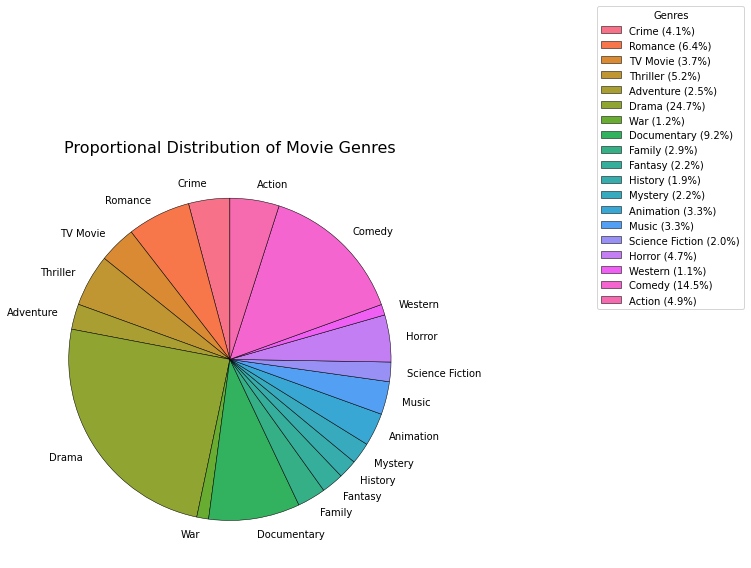

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

genre_counts_df = df_exploded.groupBy("genre").agg(count("*").alias("movie_count")).toPandas()

plt.figure(figsize=(10, 8))

colors = sns.color_palette("husl", len(genre_counts_df))

wedges, texts = plt.pie(
    genre_counts_df['movie_count'], 
    labels=genre_counts_df['genre'], 
    startangle=90, 
    colors=colors, 
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5}, 
    textprops={'fontsize': 10}  
)

plt.title("Proportional Distribution of Movie Genres", fontsize=16)

percentages = [f'{p:1.1f}%' for p in 100 * genre_counts_df['movie_count'] / genre_counts_df['movie_count'].sum()]

labels_with_percentage = [f'{genre} ({percent})' for genre, percent in zip(genre_counts_df['genre'], percentages)]

plt.legend(
    labels=labels_with_percentage, 
    title="Genres", 
    bbox_to_anchor=(1.4, 1),  
    loc='center left', 
    fontsize=10
)

plt.tight_layout()

plt.show()

#### Top movies by revenue over time

In [13]:
from pyspark.sql.functions import col

df_revenue = df_clean.select(
    "title",
    "release_year",
    "revenue"
).filter(
    (col("revenue").isNotNull()) & (col("revenue") > 0)
)

df_revenue_agg = df_revenue.groupBy("title", "release_year") \
                           .agg({"revenue": "max"}) \
                           .withColumnRenamed("max(revenue)", "total_revenue") \
                           .orderBy(col("total_revenue").desc())

df_revenue_agg.show(10)
top_movies = df_revenue_agg.limit(10).toPandas()

+--------------------+------------+-------------+
|               title|release_year|total_revenue|
+--------------------+------------+-------------+
|   Avengers: Endgame|        2019|   2799439100|
|Avatar: The Way o...|        2022|   2320250281|
|             Titanic|        1997|   2264162353|
|            Ne Zha 2|        2025|   2208800000|
|Star Wars: The Fo...|        2015|   2068223624|
|Avengers: Infinit...|        2018|   2052415039|
|Spider-Man: No Wa...|        2021|   1921847111|
|        Inside Out 2|        2024|   1698863816|
|      Jurassic World|        2015|   1671537444|
|       The Lion King|        2019|   1662020819|
+--------------------+------------+-------------+
only showing top 10 rows



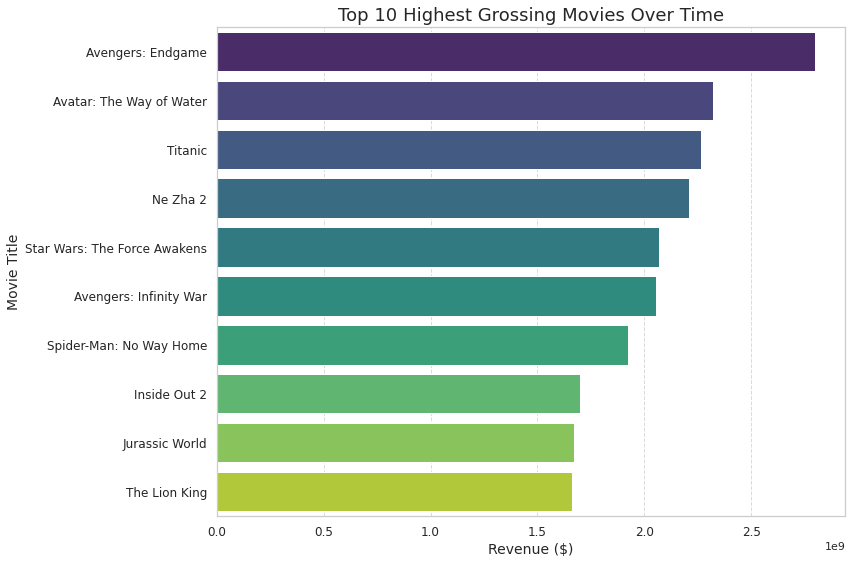

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

sns.barplot(
    data=top_movies,
    x="total_revenue",
    y="title",
    palette="viridis"  
)

plt.title("Top 10 Highest Grossing Movies Over Time", fontsize=18)
plt.xlabel("Revenue ($)", fontsize=14)
plt.ylabel("Movie Title", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, axis="x", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

### Predicting Popular Genres for 2026

In [47]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, to_date, year, regexp_replace, 
    split, explode, trim, lit, count, 
    min, max
)
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
import socket
import os
import pandas as pd

#### Data Pre Processing for Prediction

In [44]:
df = df.withColumn("release_date", to_date(col("release_date"), "yyyy-MM-dd")) \
       .withColumn("release_year", year(col("release_date"))) \
       .filter(col("release_year") <= 2025)

df_exploded = df.withColumn("genres_clean", regexp_replace(col("genres"), "[|;:/]", ",")) \
               .withColumn("genre", explode(split(col("genres_clean"), ","))) \
               .withColumn("genre", trim(col("genre"))) \
               .filter(~col("genre").isNull() & (col("genre") != ""))

#### Normalizing popularity

In [45]:
min_max = df_exploded.select(
    min("popularity").alias("min_pop"), 
    max("popularity").alias("max_pop")
).first()

min_pop = min_max["min_pop"]
max_pop = min_max["max_pop"]

df_exploded = df_exploded.withColumn(
    "rating", 
    ((col("popularity") - min_pop) / (max_pop - min_pop)) * 1000
)

#### Model Training Pipeline

In [48]:
df_train = df_exploded.filter(col("release_year") < 2026)

indexer = StringIndexer(inputCol="genre", outputCol="genre_index")
assembler = VectorAssembler(inputCols=["release_year", "genre_index"], outputCol="features")

rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="rating",
    numTrees=50,
    maxDepth=5,
    seed=42,
    featureSubsetStrategy="all"
)

pipeline = Pipeline(stages=[indexer, assembler, rf])
model = pipeline.fit(df_train)

 #### Predictions for 2026

In [49]:
genres = df_train.select("genre").distinct()
df_test = genres.withColumn("release_year", lit(2026))

In [50]:
predictions = model.transform(df_test)
results = predictions.select("genre", "prediction") \
                   .orderBy(col("prediction").desc()) \
                   .limit(10)

print("\nTop 10 Predicted Genres for 2026:")
results.show(truncate=False)


Top 10 Predicted Genres for 2026:
+---------------+------------------+
|genre          |prediction        |
+---------------+------------------+
|Adventure      |6.2895166325595335|
|Action         |6.055296638388693 |
|Family         |5.0237281200886565|
|Mystery        |4.866706398503955 |
|Fantasy        |4.788868535878233 |
|Science Fiction|4.642195045342316 |
|Thriller       |3.4195942674617843|
|Animation      |3.1069780850654762|
|Horror         |3.0456694184958724|
|Crime          |2.89681699848217  |
+---------------+------------------+



#### Evaluate the Model

In [51]:
(train_data, test_data) = df_train.randomSplit([0.8, 0.2], seed=42)
eval_model = pipeline.fit(train_data)
eval_predictions = eval_model.transform(test_data)

from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(
    labelCol="rating",
    predictionCol="prediction",
    metricName="rmse"
)
rmse = evaluator.evaluate(eval_predictions)
print(f"\nModel RMSE: {rmse:.2f}")


Model RMSE: 3.63


#### Visualize Predictions for 2026

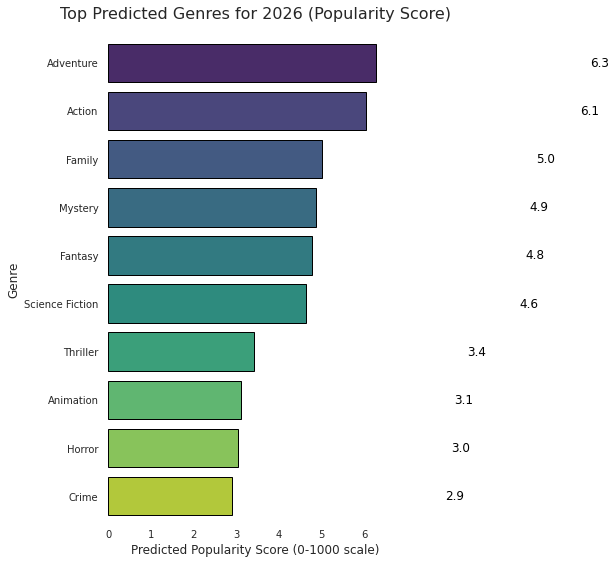

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

predictions_pd = results.toPandas()

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

ax = sns.barplot(
    x="prediction", 
    y="genre",
    data=predictions_pd,
    palette="viridis",
    edgecolor="black",
    linewidth=1
)

for i, v in enumerate(predictions_pd["prediction"]):
    ax.text(v + 5, i, f"{v:.1f}", color='black', ha='left', va='center')

plt.title("Top Predicted Genres for 2026 (Popularity Score)", fontsize=16, pad=20)
plt.xlabel("Predicted Popularity Score (0-1000 scale)", fontsize=12)
plt.ylabel("Genre", fontsize=12)
plt.xlim(0, predictions_pd["prediction"].max() * 1.1)  

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.7)

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()